In [1]:
# mostly pulled from hls4ml_3.ipynb and waveform_demo.ipynb
# last updated 2025-05-06 by mza
name = "mza_try8"
num_epochs = 10000
batch_size = 1000
hidden_nodes = [ 64 ]
hidden_node_type = "relu"
truths_to_use = [ 3 ] # t_peak, t_sigma, height, pedestal
use_pruning = False
prune_ratio = 0.1
train = True
synth_hls = True
integer_part = 1
input_quantization = 14
inner_quantization = 14
output_quantization = 14

In [2]:
import os, errno
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
try:
    os.mkdir(name)
except OSError as exception:
    if exception.errno != errno.EEXIST:
        raise

In [3]:
dataset1 = np.load('waveform_data_0.npy') # (10000, 104)
dataset2 = np.load('waveform_data_1.npy') # (10000, 104)
dataset = np.concatenate((dataset1, dataset2))
num_waveforms = len(dataset)
training_quantity = int(0.8 * num_waveforms)
num_truths = 4
time_samples = len(dataset[0]) - num_truths
print("num_waveforms: " + str(num_waveforms))
num_truths_to_use = len(truths_to_use)
print("num_truths_to_use: " + str(num_truths_to_use))
waveforms = dataset[:,num_truths:]
truths = dataset[:,:num_truths]
waveform_min = min([ min(waveforms[i]) for i in range(len(waveforms)) ])
waveform_max = max([ max(waveforms[i]) for i in range(len(waveforms)) ])
offset = waveform_min
gain = 1.0 / (waveform_max - waveform_min)
scaled_waveforms = np.array([ [ gain * (waveforms[j,i] - offset) for i in range(time_samples) ] for j in range(num_waveforms) ])
scaled_truths = np.array([ [ truths[j,0]/time_samples, truths[j,1]/time_samples, gain * (truths[j,2] - offset), gain * (truths[j,3] - offset) ] for j in range(num_waveforms) ])
train_data = scaled_waveforms[:training_quantity,:]
print("train_data.shape: " + str(train_data.shape))
train_truth = scaled_truths[:training_quantity,truths_to_use]
print("train_truth.shape: " + str(train_truth.shape))
test_data = scaled_waveforms[training_quantity:,:]
print("test_data.shape: " + str(test_data.shape))
test_truth = scaled_truths[training_quantity:,truths_to_use]
print("test_truth.shape: " + str(test_truth.shape))

num_waveforms: 20000
num_truths_to_use: 1
train_data.shape: (16000, 100)
train_truth.shape: (16000, 1)
test_data.shape: (4000, 100)
test_truth.shape: (4000, 1)


In [4]:
evt = 8
if 0:
    x = np.zeros(time_samples)
    for i in range(time_samples):
        x[i] = i/time_samples
    y = train_data[evt]
    plt.xlim(0, 1), plt.ylim(0, 1)
    plt.scatter(x, y)
    plt.plot([train_truth[evt][0], train_truth[evt][0]], [0.0, 1.0], color="green")
    plt.show()

In [5]:
print("time position of the peak: ", train_truth[evt][0]) # The 0th column: mean of the Gaussian peak

time position of the peak:  0.1934534782372811


In [6]:
import tensorflow as tf
tf.random.set_seed(seed)
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import Activation
from tensorflow.keras import optimizers
from callbacks import all_callbacks
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu, quantized_sigmoid

In [7]:
input_quantizer = quantized_bits(input_quantization, integer_part, alpha=1)
inner_quantizer = quantized_bits(inner_quantization, integer_part, alpha=1)
output_quantizer = quantized_bits(output_quantization, integer_part, alpha=1)
output_quantization_string = 'ap_fixed<' + str(output_quantization) + ',' + str(integer_part) + '>'
if hidden_node_type=="relu":
    hidden_activations = [ quantized_relu(inner_quantization) for i in range(len(hidden_nodes)) ]
else:
    hidden_activations = [ quantized_sigmoid(inner_quantization) for i in range(len(hidden_nodes)) ]
hidden_names = [ hidden_node_type for i in range(len(hidden_nodes)) ]
model = Sequential()
model.add(QDense(time_samples, input_shape=(time_samples,), name='input_qdense', kernel_quantizer=input_quantizer, bias_quantizer=input_quantizer, kernel_initializer='glorot_uniform'))
model.add(QActivation(activation=quantized_sigmoid(input_quantization), name='input_sigmoid'))
for i in range(len(hidden_nodes)):
    model.add(QDense(hidden_nodes[i], name=hidden_names[i] + str(i) + "qdense", kernel_quantizer=inner_quantizer, bias_quantizer=inner_quantizer, kernel_initializer='glorot_uniform'))
    model.add(QActivation(activation=hidden_activations[i], name=hidden_names[i] + str(i) + "activation"))
model.add(QDense(num_truths_to_use, name='output_qdense', kernel_quantizer=output_quantizer, bias_quantizer=output_quantizer, kernel_initializer='glorot_uniform'))
if num_truths_to_use<2:
    model.add(Activation(activation='sigmoid', name='output_sigmoid'))
else:
    model.add(Activation(activation='softmax', name='output_softmax'))

In [8]:
if use_pruning:
    from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
    from tensorflow_model_optimization.sparsity.keras import strip_pruning
    # the first argument is the percentage of the weights that will be forced to be 0
    pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(prune_ratio, begin_step=2000, frequency=100)}
    model = prune.prune_low_magnitude(model, **pruning_params)

In [9]:
if train:
    #optimizer = optimizers.Adam(learning_rate=0.0001)
    optimizer = optimizers.SGD(learning_rate=0.1)
    #model.compile(optimizer=optimizer, loss=['categorical_crossentropy'], metrics=['accuracy'])
    model.compile(optimizer=optimizer, loss=['mse'])
    if use_pruning:
        callbacks = all_callbacks(stop_patience=1000, lr_factor=0.5, lr_patience=10, lr_epsilon=0.000001, lr_cooldown=2, lr_minimum=0.0000001, outputDir=name)
        callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
        model.fit(train_data, train_truth, batch_size=batch_size, epochs=num_epochs, validation_split=0.25, shuffle=False, callbacks=callbacks.callbacks, verbose=0)
    else:
        model.fit(train_data, train_truth, batch_size=batch_size, epochs=num_epochs, validation_split=0.25, shuffle=False, verbose=0)
    #loss, acc = model.evaluate(test_data, test_truth, verbose=0)
    if use_pruning:
        model = strip_pruning(model)
    model.save(name + '/KERAS_check_best_model.keras')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects
    co = {}
    _add_supported_quantized_objects(co)
    model = load_model(name + '/KERAS_check_best_model.keras', custom_objects=co) # TypeError: <qkeras.qlayers.QActivation object at 0x774300567100> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

/root/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [10]:
#print('test_acc: {:.3f}, test_loss: {:.3f}'.format(acc, loss))
train_prediction = model.predict(train_data)
test_prediction = model.predict(test_data)

125/125 [==============================] - 0s 625us/step


In [11]:
evt = 5
if 0:
    print(str(test_prediction[evt]) + " : " + str(test_truth[evt]))
    x = np.zeros(time_samples)
    for i in range(time_samples):
        x[i] = i/time_samples
    y = test_data[evt]
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.scatter(x, y, color="blue")
    plt.plot([test_prediction[evt,0], test_prediction[evt,0]], [0.0, 1.0], color="red")
    plt.plot([test_truth[evt,0], test_truth[evt,0]], [0.0, 1.0], color="green")
    plt.show()

In [12]:
import csv
with open(name + '/Input.dat', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_data)
with open(name + '/Output.dat', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_prediction)

In [13]:
import hls4ml, plotting
config = hls4ml.utils.config_from_keras_model(model, granularity='name', default_reuse_factor=9)
config['LayerName']['output_sigmoid']['exp_table_t'] = output_quantization_string
config['LayerName']['output_sigmoid']['inv_table_t'] = output_quantization_string
config['LayerName']['output_sigmoid']['Precision']   = output_quantization_string
plotting.print_dict(config)
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir=name + '/hls4ml_prj', part='xc7z020clg400-1',
    input_data_tb = name + "/Input.dat", output_data_tb = name + "/Output.dat", backend='Vitis', verbose=0
)

Interpreting Sequential
Topology:
Layer name: input_qdense_input, layer type: InputLayer, input shapes: [[None, 100]], output shape: [None, 100]
Layer name: input_qdense, layer type: QDense, input shapes: [[None, 100]], output shape: [None, 100]
Layer name: input_sigmoid, layer type: HardActivation, input shapes: [[None, 100]], output shape: [None, 100]
Layer name: relu0qdense, layer type: QDense, input shapes: [[None, 100]], output shape: [None, 64]
Layer name: relu0activation, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: output_qdense, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 1]
Layer name: output_sigmoid, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]
Model
  Precision
    default:         fixed<16,6>
  ReuseFactor:       9
  Strategy:          Latency
  BramFactor:        1000000000
  TraceOutput:       False
LayerName
  input_qdense_input
    Trace:           False
    Precision
   

/root/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [14]:
from IPython.display import Image
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=name + '/hls_model.png')
#Image(name + '/hls_model.png')

In [15]:
hls_model.compile()

/root/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


Writing HLS project
Done


In [16]:
hls_train_prediction = hls_model.predict(np.ascontiguousarray(train_data))
hls_test_prediction = hls_model.predict(np.ascontiguousarray(test_data))

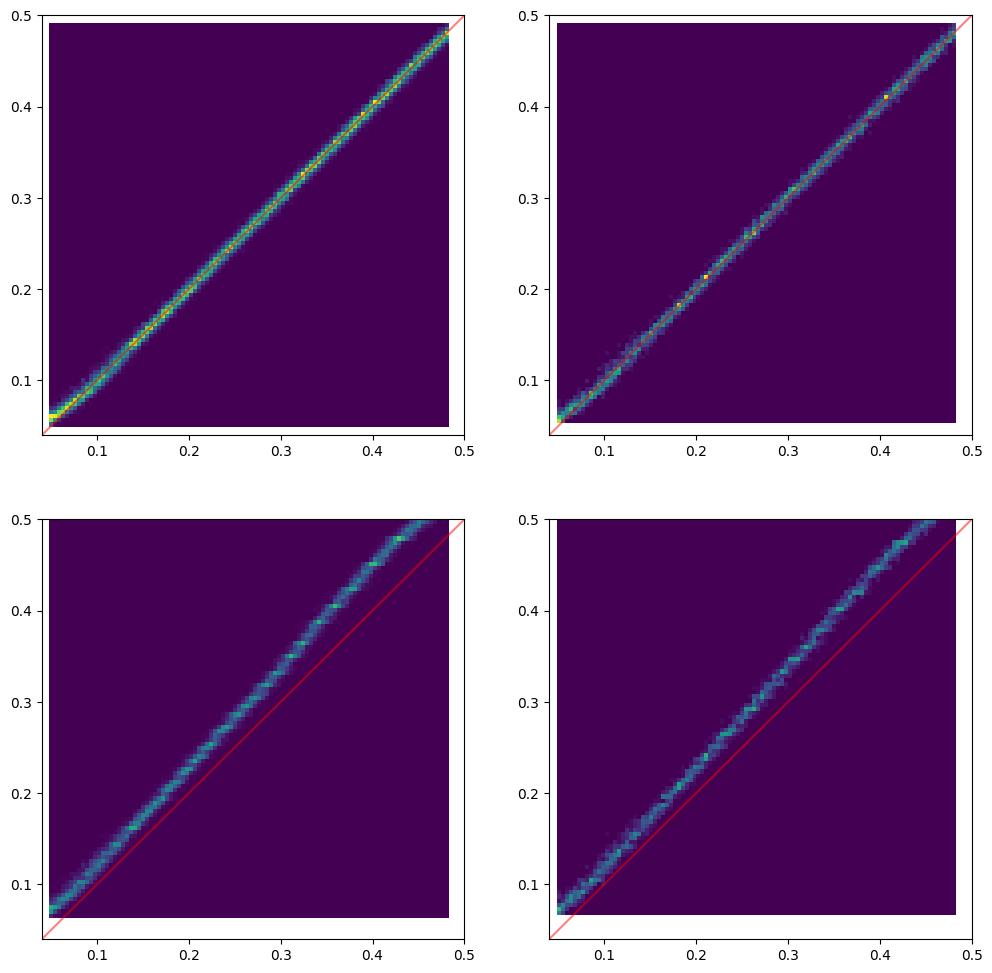

In [17]:
nbins = 100
a = 0.04; b = 0.5
for i in range(num_truths_to_use):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
    ax1.hist2d(train_truth[:,i].ravel(), train_prediction[:,i].ravel(),     bins=nbins); ax1.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax1.set_xlim(a, b); ax1.set_ylim(a, b)
    ax2.hist2d(test_truth[:,i].ravel(),  test_prediction[:,i].ravel(),      bins=nbins); ax2.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax2.set_xlim(a, b); ax2.set_ylim(a, b)
    ax3.hist2d(train_truth[:,i].ravel(), hls_train_prediction[:,i].ravel(), bins=nbins); ax3.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax3.set_xlim(a, b); ax3.set_ylim(a, b)
    ax4.hist2d(test_truth[:,i].ravel(),  hls_test_prediction[:,i].ravel(),  bins=nbins); ax4.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax4.set_xlim(a, b); ax4.set_ylim(a, b)
    plt.show()
    fig.savefig(name + "/hist2d." + str(truths_to_use[i]) + ".png")

In [18]:
if synth_hls:
    hls_model.build(synth=True, csim=True, cosim=True)


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2023.1 (64-bit)
  **** SW Build 3854077 on May  4 2023
  **** IP Build 3864474 on Sun May  7 20:36:21 MDT 2023
  **** SharedData Build 3865790 on Sun May 07 13:33:03 MDT 2023
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2023 Advanced Micro Devices, Inc. All Rights Reserved.

source /opt/Xilinx/Vitis_HLS/2023.1/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/opt/Xilinx/Vitis_HLS/2023.1/bin/unwrapped/lnx64.o/vitis_hls'
INFO: [HLS 200-10] For user 'root' on host '17425374c219' (Linux_x86_64 version 6.11.0-21-generic) on Tue May 06 14:02:51 EDT 2025
INFO: [HLS 200-10] In directory '/root/build/phys476/final_project/waveform_dataset/mza_try8/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project myproject_prj 
INFO: [HLS 200-10] Opening project '/root/build/phys476/final_project/waveform_dataset/mza_try8/hls4ml_prj/myproject_prj'.
INFO: [

INFO: [HLS 214-131] Inlining function 'nnet::product::mult<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<14, 2, (ap_q_mode)5, (ap_o_mode)3, 0> >::product(ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<14, 2, (ap_q_mode)5, (ap_o_mode)3, 0>)' into 'void nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<38, 16, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>(ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>*, ap_fixed<38, 16, (ap_q_mode)5, (ap_o_mode)3, 0>*, config2::weight_t*, config2::bias_t*)' (firmware/nnet_utils/nnet_dense_latency.h:42:27)
INFO: [HLS 214-131] Inlining function 'nnet::DenseLatency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<38, 16, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>::dense(ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>*, ap_fixed<38, 16, (ap_q_mode)5, (ap_o_mode)3, 0>*, ap_fixed<14, 2, (ap_q_mode)5, (ap_o_mode)3, 0>*, ap_fixed<14, 2, (ap_q_mode)5, (ap_o_mode)3, 0>*)' into 'void nnet::dense<ap_fixed<16, 6, (ap_q_

INFO: [HLS 200-111] Finished Standard Transforms: CPU user time: 7.33 seconds. CPU system time: 0.13 seconds. Elapsed time: 7.47 seconds; current allocated memory: 1.232 GB.
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [HLS 200-111] Finished Checking Synthesizability: CPU user time: 10.41 seconds. CPU system time: 0.01 seconds. Elapsed time: 10.43 seconds; current allocated memory: 1.217 GB.
INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<38, 16, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' into 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<38, 16, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' (firmware/nnet_utils/nnet_dense_latency.h:66) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_ufixed<14, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<36, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>' into 'nnet::dense_latency<ap_ufixed<14, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixe

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_ap_fixed_36_10_5_3_0_ap_ufixed_14_0_4_0_0_relu_config7_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'relu<ap_fixed<36, 10, 5, 3, 0>, ap_ufixed<14, 0, 4, 0, 0>, relu_config7>'.
INFO: [HLS 200-1470] Pipelining result : Target II = NA, Final II = 1, Depth = 2, function 'relu<ap_fixed<36, 10, 5, 3, 0>, ap_ufixed<14, 0, 4, 0, 0>, relu_config7>'
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111] Finished Scheduling: CPU user time: 4.32 seconds. CPU system time: 0.07 seconds. Elapsed time: 4.39 seconds; current allocated memory: 3.450 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-1

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_latency_ap_ufixed_14_0_4_0_0_ap_fixed_36_10_5_3_0_config5_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-1030] Apply Unified Pipeline Control on module 'dense_latency_ap_ufixed_14_0_4_0_0_ap_fixed_36_10_5_3_0_config5_s' pipeline 'dense_latency<ap_ufixed<14, 0, 4, 0, 0>, ap_fixed<36, 10, 5, 3, 0>, config5>' pipeline type 'function pipeline'
INFO: [RTGEN 206-104] Estimated max fanout for 'dense_latency_ap_ufixed_14_0_4_0_0_ap_fixed_36_10_5_3_0_config5_s' is 12400 from HDL expression: ((1'b0 == ap_block_pp0_stage0_11001) & (1'b1 == ap_ce) & (1'b1 == ap_CS_fsm_pp0_stage0))
INFO: [RTGEN 206-100] Generating core module 'mul_14ns_10ns_23_2_1': 6 instance(s).
INFO: [RTGEN 206-100] Generating core module 'mul_14ns_10s_22_2_1': 4 instance(s).
INFO: [RTGEN 206-100] Generating core module 'mul_14ns_10s_23_

Processing input 0
Predictions
0.399295 
Quantized predictions
0.445313 
INFO: Saved inference results to file: tb_data/rtl_cosim_results.log
INFO: [COSIM 212-333] Generating C post check test bench ...
INFO: [COSIM 212-12] Generating RTL test bench ...
INFO: [COSIM 212-1] *** C/RTL co-simulation file generation completed. ***
INFO: [HLS 200-111] Finished Command cosim_design CPU user time: 52.46 seconds. CPU system time: 4.26 seconds. Elapsed time: 56.6 seconds; current allocated memory: 0.000 MB.
INFO: [COSIM 212-302] Starting C TB testing ...  
Processing input 0
Predictions
0.399295 
Quantized predictions
0.445313 
INFO: Saved inference results to file: tb_data/rtl_cosim_results.log
INFO: [COSIM 212-323] Starting verilog simulation...
INFO: [COSIM 212-15] Starting XSIM ...
Vivado Simulator v2023.1
Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
Copyright 2022-2023 Advanced Micro Devices, Inc. All Rights Reserved.
Running: /opt/Xilinx/Vivado/2023.1/bin/unwrapped/lnx64.o/xelab 

INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/waveform_dataset/mza_try8/hls4ml_prj/myproject_prj/solution1/sim/verilog/myproject_dense_latency_ap_ufixed_14_0_4_0_0_ap_fixed_36_10_5_3_0_config5_s.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module myproject_dense_latency_ap_ufixed_14_0_4_0_0_ap_fixed_36_10_5_3_0_config5_s
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/waveform_dataset/mza_try8/hls4ml_prj/myproject_prj/solution1/sim/verilog/myproject_mul_14ns_13s_27_2_1.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module myproject_mul_14ns_13s_27_2_1
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/waveform_dataset/mza_try8/hls4ml_prj/myproject_prj/solution1/sim/verilog/myproject_mul_16s_10ns_26_2_1.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module myproject_mul_16s_10ns_26_2_1
INFO: [VRFC 10-2263] Analyzing SystemVerilog file 

// RTL Simulation : 1 / 4000 [82.35%] @ "378000"
// RTL Simulation : 2 / 4000 [82.35%] @ "423000"
// RTL Simulation : 3 / 4000 [82.35%] @ "468000"
// RTL Simulation : 4 / 4000 [82.35%] @ "513000"
// RTL Simulation : 5 / 4000 [82.35%] @ "558000"
// RTL Simulation : 6 / 4000 [82.35%] @ "603000"
// RTL Simulation : 7 / 4000 [82.35%] @ "648000"
// RTL Simulation : 8 / 4000 [82.35%] @ "693000"
// RTL Simulation : 9 / 4000 [82.35%] @ "738000"
// RTL Simulation : 10 / 4000 [82.35%] @ "783000"
// RTL Simulation : 11 / 4000 [82.35%] @ "828000"
// RTL Simulation : 12 / 4000 [82.35%] @ "873000"
// RTL Simulation : 13 / 4000 [82.35%] @ "918000"
// RTL Simulation : 14 / 4000 [82.35%] @ "963000"
// RTL Simulation : 15 / 4000 [82.35%] @ "1008000"
// RTL Simulation : 16 / 4000 [82.35%] @ "1053000"
// RTL Simulation : 17 / 4000 [82.35%] @ "1098000"
// RTL Simulation : 18 / 4000 [82.35%] @ "1143000"
// RTL Simulation : 19 / 4000 [82.35%] @ "1188000"
// RTL Simulation : 20 / 4000 [82.35%] @ "1233000"
// 

// RTL Simulation : 163 / 4000 [82.35%] @ "7668000"
// RTL Simulation : 164 / 4000 [82.35%] @ "7713000"
// RTL Simulation : 165 / 4000 [82.35%] @ "7758000"
// RTL Simulation : 166 / 4000 [82.35%] @ "7803000"
// RTL Simulation : 167 / 4000 [82.35%] @ "7848000"
// RTL Simulation : 168 / 4000 [82.35%] @ "7893000"
// RTL Simulation : 169 / 4000 [82.35%] @ "7938000"
// RTL Simulation : 170 / 4000 [82.35%] @ "7983000"
// RTL Simulation : 171 / 4000 [82.35%] @ "8028000"
// RTL Simulation : 172 / 4000 [82.35%] @ "8073000"
// RTL Simulation : 173 / 4000 [82.35%] @ "8118000"
// RTL Simulation : 174 / 4000 [82.35%] @ "8163000"
// RTL Simulation : 175 / 4000 [82.35%] @ "8208000"
// RTL Simulation : 176 / 4000 [82.35%] @ "8253000"
// RTL Simulation : 177 / 4000 [82.35%] @ "8298000"
// RTL Simulation : 178 / 4000 [82.35%] @ "8343000"
// RTL Simulation : 179 / 4000 [82.35%] @ "8388000"
// RTL Simulation : 180 / 4000 [82.35%] @ "8433000"
// RTL Simulation : 181 / 4000 [82.35%] @ "8478000"
// RTL Simul

// RTL Simulation : 319 / 4000 [82.35%] @ "14688000"
// RTL Simulation : 320 / 4000 [82.35%] @ "14733000"
// RTL Simulation : 321 / 4000 [82.35%] @ "14778000"
// RTL Simulation : 322 / 4000 [82.35%] @ "14823000"
// RTL Simulation : 323 / 4000 [82.35%] @ "14868000"
// RTL Simulation : 324 / 4000 [82.35%] @ "14913000"
// RTL Simulation : 325 / 4000 [82.35%] @ "14958000"
// RTL Simulation : 326 / 4000 [82.35%] @ "15003000"
// RTL Simulation : 327 / 4000 [82.35%] @ "15048000"
// RTL Simulation : 328 / 4000 [82.35%] @ "15093000"
// RTL Simulation : 329 / 4000 [82.35%] @ "15138000"
// RTL Simulation : 330 / 4000 [82.35%] @ "15183000"
// RTL Simulation : 331 / 4000 [82.35%] @ "15228000"
// RTL Simulation : 332 / 4000 [82.35%] @ "15273000"
// RTL Simulation : 333 / 4000 [82.35%] @ "15318000"
// RTL Simulation : 334 / 4000 [82.35%] @ "15363000"
// RTL Simulation : 335 / 4000 [82.35%] @ "15408000"
// RTL Simulation : 336 / 4000 [82.35%] @ "15453000"
// RTL Simulation : 337 / 4000 [82.35%] @ "154

// RTL Simulation : 475 / 4000 [82.35%] @ "21708000"
// RTL Simulation : 476 / 4000 [82.35%] @ "21753000"
// RTL Simulation : 477 / 4000 [82.35%] @ "21798000"
// RTL Simulation : 478 / 4000 [82.35%] @ "21843000"
// RTL Simulation : 479 / 4000 [82.35%] @ "21888000"
// RTL Simulation : 480 / 4000 [82.35%] @ "21933000"
// RTL Simulation : 481 / 4000 [82.35%] @ "21978000"
// RTL Simulation : 482 / 4000 [82.35%] @ "22023000"
// RTL Simulation : 483 / 4000 [82.35%] @ "22068000"
// RTL Simulation : 484 / 4000 [82.35%] @ "22113000"
// RTL Simulation : 485 / 4000 [82.35%] @ "22158000"
// RTL Simulation : 486 / 4000 [82.35%] @ "22203000"
// RTL Simulation : 487 / 4000 [82.35%] @ "22248000"
// RTL Simulation : 488 / 4000 [82.35%] @ "22293000"
// RTL Simulation : 489 / 4000 [82.35%] @ "22338000"
// RTL Simulation : 490 / 4000 [82.35%] @ "22383000"
// RTL Simulation : 491 / 4000 [82.35%] @ "22428000"
// RTL Simulation : 492 / 4000 [82.35%] @ "22473000"
// RTL Simulation : 493 / 4000 [82.35%] @ "225

// RTL Simulation : 631 / 4000 [82.35%] @ "28728000"
// RTL Simulation : 632 / 4000 [82.35%] @ "28773000"
// RTL Simulation : 633 / 4000 [82.35%] @ "28818000"
// RTL Simulation : 634 / 4000 [82.35%] @ "28863000"
// RTL Simulation : 635 / 4000 [82.35%] @ "28908000"
// RTL Simulation : 636 / 4000 [82.35%] @ "28953000"
// RTL Simulation : 637 / 4000 [82.35%] @ "28998000"
// RTL Simulation : 638 / 4000 [82.35%] @ "29043000"
// RTL Simulation : 639 / 4000 [82.35%] @ "29088000"
// RTL Simulation : 640 / 4000 [82.35%] @ "29133000"
// RTL Simulation : 641 / 4000 [82.35%] @ "29178000"
// RTL Simulation : 642 / 4000 [82.35%] @ "29223000"
// RTL Simulation : 643 / 4000 [82.35%] @ "29268000"
// RTL Simulation : 644 / 4000 [82.35%] @ "29313000"
// RTL Simulation : 645 / 4000 [82.35%] @ "29358000"
// RTL Simulation : 646 / 4000 [82.35%] @ "29403000"
// RTL Simulation : 647 / 4000 [82.35%] @ "29448000"
// RTL Simulation : 648 / 4000 [82.35%] @ "29493000"
// RTL Simulation : 649 / 4000 [82.35%] @ "295

// RTL Simulation : 787 / 4000 [82.35%] @ "35748000"
// RTL Simulation : 788 / 4000 [82.35%] @ "35793000"
// RTL Simulation : 789 / 4000 [82.35%] @ "35838000"
// RTL Simulation : 790 / 4000 [82.35%] @ "35883000"
// RTL Simulation : 791 / 4000 [82.35%] @ "35928000"
// RTL Simulation : 792 / 4000 [82.35%] @ "35973000"
// RTL Simulation : 793 / 4000 [82.35%] @ "36018000"
// RTL Simulation : 794 / 4000 [82.35%] @ "36063000"
// RTL Simulation : 795 / 4000 [82.35%] @ "36108000"
// RTL Simulation : 796 / 4000 [82.35%] @ "36153000"
// RTL Simulation : 797 / 4000 [82.35%] @ "36198000"
// RTL Simulation : 798 / 4000 [82.35%] @ "36243000"
// RTL Simulation : 799 / 4000 [82.35%] @ "36288000"
// RTL Simulation : 800 / 4000 [82.35%] @ "36333000"
// RTL Simulation : 801 / 4000 [82.35%] @ "36378000"
// RTL Simulation : 802 / 4000 [82.35%] @ "36423000"
// RTL Simulation : 803 / 4000 [82.35%] @ "36468000"
// RTL Simulation : 804 / 4000 [82.35%] @ "36513000"
// RTL Simulation : 805 / 4000 [82.35%] @ "365

// RTL Simulation : 943 / 4000 [82.35%] @ "42768000"
// RTL Simulation : 944 / 4000 [82.35%] @ "42813000"
// RTL Simulation : 945 / 4000 [82.35%] @ "42858000"
// RTL Simulation : 946 / 4000 [82.35%] @ "42903000"
// RTL Simulation : 947 / 4000 [82.35%] @ "42948000"
// RTL Simulation : 948 / 4000 [82.35%] @ "42993000"
// RTL Simulation : 949 / 4000 [82.35%] @ "43038000"
// RTL Simulation : 950 / 4000 [82.35%] @ "43083000"
// RTL Simulation : 951 / 4000 [82.35%] @ "43128000"
// RTL Simulation : 952 / 4000 [82.35%] @ "43173000"
// RTL Simulation : 953 / 4000 [82.35%] @ "43218000"
// RTL Simulation : 954 / 4000 [82.35%] @ "43263000"
// RTL Simulation : 955 / 4000 [82.35%] @ "43308000"
// RTL Simulation : 956 / 4000 [82.35%] @ "43353000"
// RTL Simulation : 957 / 4000 [82.35%] @ "43398000"
// RTL Simulation : 958 / 4000 [82.35%] @ "43443000"
// RTL Simulation : 959 / 4000 [82.35%] @ "43488000"
// RTL Simulation : 960 / 4000 [82.35%] @ "43533000"
// RTL Simulation : 961 / 4000 [82.35%] @ "435

// RTL Simulation : 1096 / 4000 [82.35%] @ "49653000"
// RTL Simulation : 1097 / 4000 [82.35%] @ "49698000"
// RTL Simulation : 1098 / 4000 [82.35%] @ "49743000"
// RTL Simulation : 1099 / 4000 [82.35%] @ "49788000"
// RTL Simulation : 1100 / 4000 [82.35%] @ "49833000"
// RTL Simulation : 1101 / 4000 [82.35%] @ "49878000"
// RTL Simulation : 1102 / 4000 [82.35%] @ "49923000"
// RTL Simulation : 1103 / 4000 [82.35%] @ "49968000"
// RTL Simulation : 1104 / 4000 [82.35%] @ "50013000"
// RTL Simulation : 1105 / 4000 [82.35%] @ "50058000"
// RTL Simulation : 1106 / 4000 [82.35%] @ "50103000"
// RTL Simulation : 1107 / 4000 [82.35%] @ "50148000"
// RTL Simulation : 1108 / 4000 [82.35%] @ "50193000"
// RTL Simulation : 1109 / 4000 [82.35%] @ "50238000"
// RTL Simulation : 1110 / 4000 [82.35%] @ "50283000"
// RTL Simulation : 1111 / 4000 [82.35%] @ "50328000"
// RTL Simulation : 1112 / 4000 [82.35%] @ "50373000"
// RTL Simulation : 1113 / 4000 [82.35%] @ "50418000"
// RTL Simulation : 1114 / 4

// RTL Simulation : 1249 / 4000 [82.35%] @ "56538000"
// RTL Simulation : 1250 / 4000 [82.35%] @ "56583000"
// RTL Simulation : 1251 / 4000 [82.35%] @ "56628000"
// RTL Simulation : 1252 / 4000 [82.35%] @ "56673000"
// RTL Simulation : 1253 / 4000 [82.35%] @ "56718000"
// RTL Simulation : 1254 / 4000 [82.35%] @ "56763000"
// RTL Simulation : 1255 / 4000 [82.35%] @ "56808000"
// RTL Simulation : 1256 / 4000 [82.35%] @ "56853000"
// RTL Simulation : 1257 / 4000 [82.35%] @ "56898000"
// RTL Simulation : 1258 / 4000 [82.35%] @ "56943000"
// RTL Simulation : 1259 / 4000 [82.35%] @ "56988000"
// RTL Simulation : 1260 / 4000 [82.35%] @ "57033000"
// RTL Simulation : 1261 / 4000 [82.35%] @ "57078000"
// RTL Simulation : 1262 / 4000 [82.35%] @ "57123000"
// RTL Simulation : 1263 / 4000 [82.35%] @ "57168000"
// RTL Simulation : 1264 / 4000 [82.35%] @ "57213000"
// RTL Simulation : 1265 / 4000 [82.35%] @ "57258000"
// RTL Simulation : 1266 / 4000 [82.35%] @ "57303000"
// RTL Simulation : 1267 / 4

// RTL Simulation : 1402 / 4000 [82.35%] @ "63423000"
// RTL Simulation : 1403 / 4000 [82.35%] @ "63468000"
// RTL Simulation : 1404 / 4000 [82.35%] @ "63513000"
// RTL Simulation : 1405 / 4000 [82.35%] @ "63558000"
// RTL Simulation : 1406 / 4000 [82.35%] @ "63603000"
// RTL Simulation : 1407 / 4000 [82.35%] @ "63648000"
// RTL Simulation : 1408 / 4000 [82.35%] @ "63693000"
// RTL Simulation : 1409 / 4000 [82.35%] @ "63738000"
// RTL Simulation : 1410 / 4000 [82.35%] @ "63783000"
// RTL Simulation : 1411 / 4000 [82.35%] @ "63828000"
// RTL Simulation : 1412 / 4000 [82.35%] @ "63873000"
// RTL Simulation : 1413 / 4000 [82.35%] @ "63918000"
// RTL Simulation : 1414 / 4000 [82.35%] @ "63963000"
// RTL Simulation : 1415 / 4000 [82.35%] @ "64008000"
// RTL Simulation : 1416 / 4000 [82.35%] @ "64053000"
// RTL Simulation : 1417 / 4000 [82.35%] @ "64098000"
// RTL Simulation : 1418 / 4000 [82.35%] @ "64143000"
// RTL Simulation : 1419 / 4000 [82.35%] @ "64188000"
// RTL Simulation : 1420 / 4

// RTL Simulation : 1555 / 4000 [82.35%] @ "70308000"
// RTL Simulation : 1556 / 4000 [82.35%] @ "70353000"
// RTL Simulation : 1557 / 4000 [82.35%] @ "70398000"
// RTL Simulation : 1558 / 4000 [82.35%] @ "70443000"
// RTL Simulation : 1559 / 4000 [82.35%] @ "70488000"
// RTL Simulation : 1560 / 4000 [82.35%] @ "70533000"
// RTL Simulation : 1561 / 4000 [82.35%] @ "70578000"
// RTL Simulation : 1562 / 4000 [82.35%] @ "70623000"
// RTL Simulation : 1563 / 4000 [82.35%] @ "70668000"
// RTL Simulation : 1564 / 4000 [82.35%] @ "70713000"
// RTL Simulation : 1565 / 4000 [82.35%] @ "70758000"
// RTL Simulation : 1566 / 4000 [82.35%] @ "70803000"
// RTL Simulation : 1567 / 4000 [82.35%] @ "70848000"
// RTL Simulation : 1568 / 4000 [82.35%] @ "70893000"
// RTL Simulation : 1569 / 4000 [82.35%] @ "70938000"
// RTL Simulation : 1570 / 4000 [82.35%] @ "70983000"
// RTL Simulation : 1571 / 4000 [82.35%] @ "71028000"
// RTL Simulation : 1572 / 4000 [82.35%] @ "71073000"
// RTL Simulation : 1573 / 4

// RTL Simulation : 1708 / 4000 [82.35%] @ "77193000"
// RTL Simulation : 1709 / 4000 [82.35%] @ "77238000"
// RTL Simulation : 1710 / 4000 [82.35%] @ "77283000"
// RTL Simulation : 1711 / 4000 [82.35%] @ "77328000"
// RTL Simulation : 1712 / 4000 [82.35%] @ "77373000"
// RTL Simulation : 1713 / 4000 [82.35%] @ "77418000"
// RTL Simulation : 1714 / 4000 [82.35%] @ "77463000"
// RTL Simulation : 1715 / 4000 [82.35%] @ "77508000"
// RTL Simulation : 1716 / 4000 [82.35%] @ "77553000"
// RTL Simulation : 1717 / 4000 [82.35%] @ "77598000"
// RTL Simulation : 1718 / 4000 [82.35%] @ "77643000"
// RTL Simulation : 1719 / 4000 [82.35%] @ "77688000"
// RTL Simulation : 1720 / 4000 [82.35%] @ "77733000"
// RTL Simulation : 1721 / 4000 [82.35%] @ "77778000"
// RTL Simulation : 1722 / 4000 [82.35%] @ "77823000"
// RTL Simulation : 1723 / 4000 [82.35%] @ "77868000"
// RTL Simulation : 1724 / 4000 [82.35%] @ "77913000"
// RTL Simulation : 1725 / 4000 [82.35%] @ "77958000"
// RTL Simulation : 1726 / 4

// RTL Simulation : 1860 / 4000 [82.35%] @ "84033000"
// RTL Simulation : 1861 / 4000 [82.35%] @ "84078000"
// RTL Simulation : 1862 / 4000 [82.35%] @ "84123000"
// RTL Simulation : 1863 / 4000 [82.35%] @ "84168000"
// RTL Simulation : 1864 / 4000 [82.35%] @ "84213000"
// RTL Simulation : 1865 / 4000 [82.35%] @ "84258000"
// RTL Simulation : 1866 / 4000 [82.35%] @ "84303000"
// RTL Simulation : 1867 / 4000 [82.35%] @ "84348000"
// RTL Simulation : 1868 / 4000 [82.35%] @ "84393000"
// RTL Simulation : 1869 / 4000 [82.35%] @ "84438000"
// RTL Simulation : 1870 / 4000 [82.35%] @ "84483000"
// RTL Simulation : 1871 / 4000 [82.35%] @ "84528000"
// RTL Simulation : 1872 / 4000 [82.35%] @ "84573000"
// RTL Simulation : 1873 / 4000 [82.35%] @ "84618000"
// RTL Simulation : 1874 / 4000 [82.35%] @ "84663000"
// RTL Simulation : 1875 / 4000 [82.35%] @ "84708000"
// RTL Simulation : 1876 / 4000 [82.35%] @ "84753000"
// RTL Simulation : 1877 / 4000 [82.35%] @ "84798000"
// RTL Simulation : 1878 / 4

// RTL Simulation : 2012 / 4000 [82.35%] @ "90873000"
// RTL Simulation : 2013 / 4000 [82.35%] @ "90918000"
// RTL Simulation : 2014 / 4000 [82.35%] @ "90963000"
// RTL Simulation : 2015 / 4000 [82.35%] @ "91008000"
// RTL Simulation : 2016 / 4000 [82.35%] @ "91053000"
// RTL Simulation : 2017 / 4000 [82.35%] @ "91098000"
// RTL Simulation : 2018 / 4000 [82.35%] @ "91143000"
// RTL Simulation : 2019 / 4000 [82.35%] @ "91188000"
// RTL Simulation : 2020 / 4000 [82.35%] @ "91233000"
// RTL Simulation : 2021 / 4000 [82.35%] @ "91278000"
// RTL Simulation : 2022 / 4000 [82.35%] @ "91323000"
// RTL Simulation : 2023 / 4000 [82.35%] @ "91368000"
// RTL Simulation : 2024 / 4000 [82.35%] @ "91413000"
// RTL Simulation : 2025 / 4000 [82.35%] @ "91458000"
// RTL Simulation : 2026 / 4000 [82.35%] @ "91503000"
// RTL Simulation : 2027 / 4000 [82.35%] @ "91548000"
// RTL Simulation : 2028 / 4000 [82.35%] @ "91593000"
// RTL Simulation : 2029 / 4000 [82.35%] @ "91638000"
// RTL Simulation : 2030 / 4

// RTL Simulation : 2164 / 4000 [82.35%] @ "97713000"
// RTL Simulation : 2165 / 4000 [82.35%] @ "97758000"
// RTL Simulation : 2166 / 4000 [82.35%] @ "97803000"
// RTL Simulation : 2167 / 4000 [82.35%] @ "97848000"
// RTL Simulation : 2168 / 4000 [82.35%] @ "97893000"
// RTL Simulation : 2169 / 4000 [82.35%] @ "97938000"
// RTL Simulation : 2170 / 4000 [82.35%] @ "97983000"
// RTL Simulation : 2171 / 4000 [82.35%] @ "98028000"
// RTL Simulation : 2172 / 4000 [82.35%] @ "98073000"
// RTL Simulation : 2173 / 4000 [82.35%] @ "98118000"
// RTL Simulation : 2174 / 4000 [82.35%] @ "98163000"
// RTL Simulation : 2175 / 4000 [82.35%] @ "98208000"
// RTL Simulation : 2176 / 4000 [82.35%] @ "98253000"
// RTL Simulation : 2177 / 4000 [82.35%] @ "98298000"
// RTL Simulation : 2178 / 4000 [82.35%] @ "98343000"
// RTL Simulation : 2179 / 4000 [82.35%] @ "98388000"
// RTL Simulation : 2180 / 4000 [82.35%] @ "98433000"
// RTL Simulation : 2181 / 4000 [82.35%] @ "98478000"
// RTL Simulation : 2182 / 4

// RTL Simulation : 2316 / 4000 [82.35%] @ "104553000"
// RTL Simulation : 2317 / 4000 [82.35%] @ "104598000"
// RTL Simulation : 2318 / 4000 [82.35%] @ "104643000"
// RTL Simulation : 2319 / 4000 [82.35%] @ "104688000"
// RTL Simulation : 2320 / 4000 [82.35%] @ "104733000"
// RTL Simulation : 2321 / 4000 [82.35%] @ "104778000"
// RTL Simulation : 2322 / 4000 [82.35%] @ "104823000"
// RTL Simulation : 2323 / 4000 [82.35%] @ "104868000"
// RTL Simulation : 2324 / 4000 [82.35%] @ "104913000"
// RTL Simulation : 2325 / 4000 [82.35%] @ "104958000"
// RTL Simulation : 2326 / 4000 [82.35%] @ "105003000"
// RTL Simulation : 2327 / 4000 [82.35%] @ "105048000"
// RTL Simulation : 2328 / 4000 [82.35%] @ "105093000"
// RTL Simulation : 2329 / 4000 [82.35%] @ "105138000"
// RTL Simulation : 2330 / 4000 [82.35%] @ "105183000"
// RTL Simulation : 2331 / 4000 [82.35%] @ "105228000"
// RTL Simulation : 2332 / 4000 [82.35%] @ "105273000"
// RTL Simulation : 2333 / 4000 [82.35%] @ "105318000"
// RTL Sim

// RTL Simulation : 2468 / 4000 [82.35%] @ "111393000"
// RTL Simulation : 2469 / 4000 [82.35%] @ "111438000"
// RTL Simulation : 2470 / 4000 [82.35%] @ "111483000"
// RTL Simulation : 2471 / 4000 [82.35%] @ "111528000"
// RTL Simulation : 2472 / 4000 [82.35%] @ "111573000"
// RTL Simulation : 2473 / 4000 [82.35%] @ "111618000"
// RTL Simulation : 2474 / 4000 [82.35%] @ "111663000"
// RTL Simulation : 2475 / 4000 [82.35%] @ "111708000"
// RTL Simulation : 2476 / 4000 [82.35%] @ "111753000"
// RTL Simulation : 2477 / 4000 [82.35%] @ "111798000"
// RTL Simulation : 2478 / 4000 [82.35%] @ "111843000"
// RTL Simulation : 2479 / 4000 [82.35%] @ "111888000"
// RTL Simulation : 2480 / 4000 [82.35%] @ "111933000"
// RTL Simulation : 2481 / 4000 [82.35%] @ "111978000"
// RTL Simulation : 2482 / 4000 [82.35%] @ "112023000"
// RTL Simulation : 2483 / 4000 [82.35%] @ "112068000"
// RTL Simulation : 2484 / 4000 [82.35%] @ "112113000"
// RTL Simulation : 2485 / 4000 [82.35%] @ "112158000"
// RTL Sim

// RTL Simulation : 2620 / 4000 [82.35%] @ "118233000"
// RTL Simulation : 2621 / 4000 [82.35%] @ "118278000"
// RTL Simulation : 2622 / 4000 [82.35%] @ "118323000"
// RTL Simulation : 2623 / 4000 [82.35%] @ "118368000"
// RTL Simulation : 2624 / 4000 [82.35%] @ "118413000"
// RTL Simulation : 2625 / 4000 [82.35%] @ "118458000"
// RTL Simulation : 2626 / 4000 [82.35%] @ "118503000"
// RTL Simulation : 2627 / 4000 [82.35%] @ "118548000"
// RTL Simulation : 2628 / 4000 [82.35%] @ "118593000"
// RTL Simulation : 2629 / 4000 [82.35%] @ "118638000"
// RTL Simulation : 2630 / 4000 [82.35%] @ "118683000"
// RTL Simulation : 2631 / 4000 [82.35%] @ "118728000"
// RTL Simulation : 2632 / 4000 [82.35%] @ "118773000"
// RTL Simulation : 2633 / 4000 [82.35%] @ "118818000"
// RTL Simulation : 2634 / 4000 [82.35%] @ "118863000"
// RTL Simulation : 2635 / 4000 [82.35%] @ "118908000"
// RTL Simulation : 2636 / 4000 [82.35%] @ "118953000"
// RTL Simulation : 2637 / 4000 [82.35%] @ "118998000"
// RTL Sim

// RTL Simulation : 2772 / 4000 [82.35%] @ "125073000"
// RTL Simulation : 2773 / 4000 [82.35%] @ "125118000"
// RTL Simulation : 2774 / 4000 [82.35%] @ "125163000"
// RTL Simulation : 2775 / 4000 [82.35%] @ "125208000"
// RTL Simulation : 2776 / 4000 [82.35%] @ "125253000"
// RTL Simulation : 2777 / 4000 [82.35%] @ "125298000"
// RTL Simulation : 2778 / 4000 [82.35%] @ "125343000"
// RTL Simulation : 2779 / 4000 [82.35%] @ "125388000"
// RTL Simulation : 2780 / 4000 [82.35%] @ "125433000"
// RTL Simulation : 2781 / 4000 [82.35%] @ "125478000"
// RTL Simulation : 2782 / 4000 [82.35%] @ "125523000"
// RTL Simulation : 2783 / 4000 [82.35%] @ "125568000"
// RTL Simulation : 2784 / 4000 [82.35%] @ "125613000"
// RTL Simulation : 2785 / 4000 [82.35%] @ "125658000"
// RTL Simulation : 2786 / 4000 [82.35%] @ "125703000"
// RTL Simulation : 2787 / 4000 [82.35%] @ "125748000"
// RTL Simulation : 2788 / 4000 [82.35%] @ "125793000"
// RTL Simulation : 2789 / 4000 [82.35%] @ "125838000"
// RTL Sim

// RTL Simulation : 2924 / 4000 [82.35%] @ "131913000"
// RTL Simulation : 2925 / 4000 [82.35%] @ "131958000"
// RTL Simulation : 2926 / 4000 [82.35%] @ "132003000"
// RTL Simulation : 2927 / 4000 [82.35%] @ "132048000"
// RTL Simulation : 2928 / 4000 [82.35%] @ "132093000"
// RTL Simulation : 2929 / 4000 [82.35%] @ "132138000"
// RTL Simulation : 2930 / 4000 [82.35%] @ "132183000"
// RTL Simulation : 2931 / 4000 [82.35%] @ "132228000"
// RTL Simulation : 2932 / 4000 [82.35%] @ "132273000"
// RTL Simulation : 2933 / 4000 [82.35%] @ "132318000"
// RTL Simulation : 2934 / 4000 [82.35%] @ "132363000"
// RTL Simulation : 2935 / 4000 [82.35%] @ "132408000"
// RTL Simulation : 2936 / 4000 [82.35%] @ "132453000"
// RTL Simulation : 2937 / 4000 [82.35%] @ "132498000"
// RTL Simulation : 2938 / 4000 [82.35%] @ "132543000"
// RTL Simulation : 2939 / 4000 [82.35%] @ "132588000"
// RTL Simulation : 2940 / 4000 [82.35%] @ "132633000"
// RTL Simulation : 2941 / 4000 [82.35%] @ "132678000"
// RTL Sim

// RTL Simulation : 3076 / 4000 [82.35%] @ "138753000"
// RTL Simulation : 3077 / 4000 [82.35%] @ "138798000"
// RTL Simulation : 3078 / 4000 [82.35%] @ "138843000"
// RTL Simulation : 3079 / 4000 [82.35%] @ "138888000"
// RTL Simulation : 3080 / 4000 [82.35%] @ "138933000"
// RTL Simulation : 3081 / 4000 [82.35%] @ "138978000"
// RTL Simulation : 3082 / 4000 [82.35%] @ "139023000"
// RTL Simulation : 3083 / 4000 [82.35%] @ "139068000"
// RTL Simulation : 3084 / 4000 [82.35%] @ "139113000"
// RTL Simulation : 3085 / 4000 [82.35%] @ "139158000"
// RTL Simulation : 3086 / 4000 [82.35%] @ "139203000"
// RTL Simulation : 3087 / 4000 [82.35%] @ "139248000"
// RTL Simulation : 3088 / 4000 [82.35%] @ "139293000"
// RTL Simulation : 3089 / 4000 [82.35%] @ "139338000"
// RTL Simulation : 3090 / 4000 [82.35%] @ "139383000"
// RTL Simulation : 3091 / 4000 [82.35%] @ "139428000"
// RTL Simulation : 3092 / 4000 [82.35%] @ "139473000"
// RTL Simulation : 3093 / 4000 [82.35%] @ "139518000"
// RTL Sim

// RTL Simulation : 3228 / 4000 [82.35%] @ "145593000"
// RTL Simulation : 3229 / 4000 [82.35%] @ "145638000"
// RTL Simulation : 3230 / 4000 [82.35%] @ "145683000"
// RTL Simulation : 3231 / 4000 [82.35%] @ "145728000"
// RTL Simulation : 3232 / 4000 [82.35%] @ "145773000"
// RTL Simulation : 3233 / 4000 [82.35%] @ "145818000"
// RTL Simulation : 3234 / 4000 [82.35%] @ "145863000"
// RTL Simulation : 3235 / 4000 [82.35%] @ "145908000"
// RTL Simulation : 3236 / 4000 [82.35%] @ "145953000"
// RTL Simulation : 3237 / 4000 [82.35%] @ "145998000"
// RTL Simulation : 3238 / 4000 [82.35%] @ "146043000"
// RTL Simulation : 3239 / 4000 [82.35%] @ "146088000"
// RTL Simulation : 3240 / 4000 [82.35%] @ "146133000"
// RTL Simulation : 3241 / 4000 [82.35%] @ "146178000"
// RTL Simulation : 3242 / 4000 [82.35%] @ "146223000"
// RTL Simulation : 3243 / 4000 [82.35%] @ "146268000"
// RTL Simulation : 3244 / 4000 [82.35%] @ "146313000"
// RTL Simulation : 3245 / 4000 [82.35%] @ "146358000"
// RTL Sim

// RTL Simulation : 3380 / 4000 [82.35%] @ "152433000"
// RTL Simulation : 3381 / 4000 [82.35%] @ "152478000"
// RTL Simulation : 3382 / 4000 [82.35%] @ "152523000"
// RTL Simulation : 3383 / 4000 [82.35%] @ "152568000"
// RTL Simulation : 3384 / 4000 [82.35%] @ "152613000"
// RTL Simulation : 3385 / 4000 [82.35%] @ "152658000"
// RTL Simulation : 3386 / 4000 [82.35%] @ "152703000"
// RTL Simulation : 3387 / 4000 [82.35%] @ "152748000"
// RTL Simulation : 3388 / 4000 [82.35%] @ "152793000"
// RTL Simulation : 3389 / 4000 [82.35%] @ "152838000"
// RTL Simulation : 3390 / 4000 [82.35%] @ "152883000"
// RTL Simulation : 3391 / 4000 [82.35%] @ "152928000"
// RTL Simulation : 3392 / 4000 [82.35%] @ "152973000"
// RTL Simulation : 3393 / 4000 [82.35%] @ "153018000"
// RTL Simulation : 3394 / 4000 [82.35%] @ "153063000"
// RTL Simulation : 3395 / 4000 [82.35%] @ "153108000"
// RTL Simulation : 3396 / 4000 [82.35%] @ "153153000"
// RTL Simulation : 3397 / 4000 [82.35%] @ "153198000"
// RTL Sim

// RTL Simulation : 3531 / 4000 [82.35%] @ "159228000"
// RTL Simulation : 3532 / 4000 [82.35%] @ "159273000"
// RTL Simulation : 3533 / 4000 [82.35%] @ "159318000"
// RTL Simulation : 3534 / 4000 [82.35%] @ "159363000"
// RTL Simulation : 3535 / 4000 [82.35%] @ "159408000"
// RTL Simulation : 3536 / 4000 [82.35%] @ "159453000"
// RTL Simulation : 3537 / 4000 [82.35%] @ "159498000"
// RTL Simulation : 3538 / 4000 [82.35%] @ "159543000"
// RTL Simulation : 3539 / 4000 [82.35%] @ "159588000"
// RTL Simulation : 3540 / 4000 [82.35%] @ "159633000"
// RTL Simulation : 3541 / 4000 [82.35%] @ "159678000"
// RTL Simulation : 3542 / 4000 [82.35%] @ "159723000"
// RTL Simulation : 3543 / 4000 [82.35%] @ "159768000"
// RTL Simulation : 3544 / 4000 [82.35%] @ "159813000"
// RTL Simulation : 3545 / 4000 [82.35%] @ "159858000"
// RTL Simulation : 3546 / 4000 [82.35%] @ "159903000"
// RTL Simulation : 3547 / 4000 [82.35%] @ "159948000"
// RTL Simulation : 3548 / 4000 [82.35%] @ "159993000"
// RTL Sim

// RTL Simulation : 3683 / 4000 [82.35%] @ "166068000"
// RTL Simulation : 3684 / 4000 [82.35%] @ "166113000"
// RTL Simulation : 3685 / 4000 [82.35%] @ "166158000"
// RTL Simulation : 3686 / 4000 [82.35%] @ "166203000"
// RTL Simulation : 3687 / 4000 [82.35%] @ "166248000"
// RTL Simulation : 3688 / 4000 [82.35%] @ "166293000"
// RTL Simulation : 3689 / 4000 [82.35%] @ "166338000"
// RTL Simulation : 3690 / 4000 [82.35%] @ "166383000"
// RTL Simulation : 3691 / 4000 [82.35%] @ "166428000"
// RTL Simulation : 3692 / 4000 [82.35%] @ "166473000"
// RTL Simulation : 3693 / 4000 [82.35%] @ "166518000"
// RTL Simulation : 3694 / 4000 [82.35%] @ "166563000"
// RTL Simulation : 3695 / 4000 [82.35%] @ "166608000"
// RTL Simulation : 3696 / 4000 [82.35%] @ "166653000"
// RTL Simulation : 3697 / 4000 [82.35%] @ "166698000"
// RTL Simulation : 3698 / 4000 [82.35%] @ "166743000"
// RTL Simulation : 3699 / 4000 [82.35%] @ "166788000"
// RTL Simulation : 3700 / 4000 [82.35%] @ "166833000"
// RTL Sim

// RTL Simulation : 3835 / 4000 [82.35%] @ "172908000"
// RTL Simulation : 3836 / 4000 [82.35%] @ "172953000"
// RTL Simulation : 3837 / 4000 [82.35%] @ "172998000"
// RTL Simulation : 3838 / 4000 [82.35%] @ "173043000"
// RTL Simulation : 3839 / 4000 [82.35%] @ "173088000"
// RTL Simulation : 3840 / 4000 [82.35%] @ "173133000"
// RTL Simulation : 3841 / 4000 [82.35%] @ "173178000"
// RTL Simulation : 3842 / 4000 [82.35%] @ "173223000"
// RTL Simulation : 3843 / 4000 [82.35%] @ "173268000"
// RTL Simulation : 3844 / 4000 [82.35%] @ "173313000"
// RTL Simulation : 3845 / 4000 [82.35%] @ "173358000"
// RTL Simulation : 3846 / 4000 [82.35%] @ "173403000"
// RTL Simulation : 3847 / 4000 [82.35%] @ "173448000"
// RTL Simulation : 3848 / 4000 [82.35%] @ "173493000"
// RTL Simulation : 3849 / 4000 [82.35%] @ "173538000"
// RTL Simulation : 3850 / 4000 [82.35%] @ "173583000"
// RTL Simulation : 3851 / 4000 [82.35%] @ "173628000"
// RTL Simulation : 3852 / 4000 [82.35%] @ "173673000"
// RTL Sim

// RTL Simulation : 3987 / 4000 [82.35%] @ "179748000"
// RTL Simulation : 3988 / 4000 [82.35%] @ "179793000"
// RTL Simulation : 3989 / 4000 [82.35%] @ "179838000"
// RTL Simulation : 3990 / 4000 [82.35%] @ "179883000"
// RTL Simulation : 3991 / 4000 [82.35%] @ "179928000"
// RTL Simulation : 3992 / 4000 [82.35%] @ "179973000"
// RTL Simulation : 3993 / 4000 [82.35%] @ "180018000"
// RTL Simulation : 3994 / 4000 [82.35%] @ "180063000"
// RTL Simulation : 3995 / 4000 [82.35%] @ "180108000"
// RTL Simulation : 3996 / 4000 [82.35%] @ "180153000"
// RTL Simulation : 3997 / 4000 [82.35%] @ "180198000"
// RTL Simulation : 3998 / 4000 [82.35%] @ "180243000"
// RTL Simulation : 3999 / 4000 [82.35%] @ "180288000"
// RTL Simulation : 4000 / 4000 [100.00%] @ "180333000"
////////////////////////////////////////////////////////////////////////////////////
$finish called at time : 180362500 ps : File "/root/build/phys476/final_project/waveform_dataset/mza_try8/hls4ml_prj/myproject_prj/solution1/sim

In [19]:
if synth_hls:
    hls4ml.report.read_vivado_report(name + '/hls4ml_prj') # requires 1911 DSPs; 1635 DSPs when DefaultReuseFactor=9

Found 1 solution(s) in mza_try8/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../myproject_test.cpp in debug mode
   Compiling ../../../../firmware/myproject.cpp in debug mode
   Generating csim.exe
Processing input 0
Predictions
0.399295 
Quantized predictions
0.445313 
INFO: Saved inference results to file: tb_data/csim_results.log
INFO: [SIM 1] CSim done with 0 errors.
INFO: [SIM 3] *************** CSIM finish ***************

SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Tue May  6 14:58:15 2025

* Version:        2023.1 (Build 3854077 on May  4 2023)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: zynq
* Target device:  xc7z020-clg400-1


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
